In [105]:
import torch
import torch.nn.functional as F
import torch.nn as nn

import fastai.vision.all as fai

from torchvision import transforms
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline
import random

In [106]:
path_to_imgs = fai.untar_data(fai.URLs.MNIST)

In [107]:
path_to_imgs

Path('/Users/mxz/.fastai/data/mnist_png')

In [108]:
path_to_imgs.ls()

(#2) [Path('/Users/mxz/.fastai/data/mnist_png/training'),Path('/Users/mxz/.fastai/data/mnist_png/testing')]

In [109]:
numbers_to_detect = 9

In [110]:
training_image_tensors = torch.cat(
    [transforms.PILToTensor()(Image.open(x)) 
     for i in range(1, numbers_to_detect+1) 
     for x in (path_to_imgs/f'training/{i}').ls().sorted()]
).float()

testing_image_tensors = torch.cat(
    [transforms.PILToTensor()(Image.open(x)) 
     for i in range(1, numbers_to_detect+1) 
     for x in (path_to_imgs/f'testing/{i}').ls().sorted()]
).float()
training_y = torch.stack([torch.tensor(i-1)
     for i in range(1, numbers_to_detect+1) 
     for x in (path_to_imgs/f'training/{i}').ls().sorted()])
testing_y = torch.stack([torch.tensor(i-1)
     for i in range(1, numbers_to_detect+1) 
     for x in (path_to_imgs/f'testing/{i}').ls().sorted()])
training_image_tensors.size(), training_y.size(), testing_image_tensors.size(), testing_y.size(), testing_y[0]

(torch.Size([54077, 28, 28]),
 torch.Size([54077]),
 torch.Size([9020, 28, 28]),
 torch.Size([9020]),
 tensor(0))

In [111]:
n_neurons = numbers_to_detect

# l1
w1 = torch.randn((28*28, n_neurons)) * 0.1
params = [w1]

# l2 attempts
# hidden_neurons = 32  # Intermediate feature size
# w1 = torch.randn((28*28, hidden_neurons)) * 0.01  
# w2 = torch.randn((hidden_neurons, n_neurons)) * 0.01  
# b1 = torch.zeros(hidden_neurons)
# b2 = torch.zeros(n_neurons)
# params = [w1, b1, w2, b2]

        
for p in params:
    p.requires_grad = True


x_tr = training_image_tensors.view((training_image_tensors.size()[0], training_image_tensors.size()[1]**2))
y_tr = training_y
x_test = testing_image_tensors.view((testing_image_tensors.size()[0], testing_image_tensors.size()[1]**2))
y_test = testing_y

steps = []
losses = []
counter = 0

n_epoch = 2
tr_samples_len = x_tr.size()[0]
test_samples_len = x_test.size()[0]
indices = torch.randperm(tr_samples_len)

print(w1.size())
print(x_tr.size())
print(y_tr.size())
print(tr_samples_len)

torch.Size([784, 9])
torch.Size([54077, 784])
torch.Size([54077])
54077


In [112]:
for epoch in range(n_epoch):
    for i in range(tr_samples_len):
        idx = indices[i]
        x = x_tr[idx]
        y = y_tr[idx]

        logits = (x @ w1)
        logits_min, logits_max = logits.min(), logits.max()
        logits_scaled = (logits - logits_min) / (logits_max - logits_min)
        preds = torch.softmax(logits_scaled, dim=0)  


        # l1 = (x @ w1) + b1
        # l1_activated = torch.relu(l1)  # First layer with ReLU
        # logits = (l1_activated @ w2) + b2  # Second layer (output)
        # loss = F.cross_entropy(logits.unsqueeze(0), y.unsqueeze(0))
        # TODO: What it does, how can be done manually? Why we need it?
        # torch.nn.utils.clip_grad_norm_(params, max_norm=25.0)
        
        loss = -torch.log(preds[y])
        
        for p in params:
                p.grad = None
        loss.backward()
        
        # # update
        lr = 0.5 if counter < tr_samples_len // 2 else 0.01
        for p in params:
             p.data -= lr * p.grad
            
        steps.append(counter)
        losses.append(loss.item())
        counter += 1

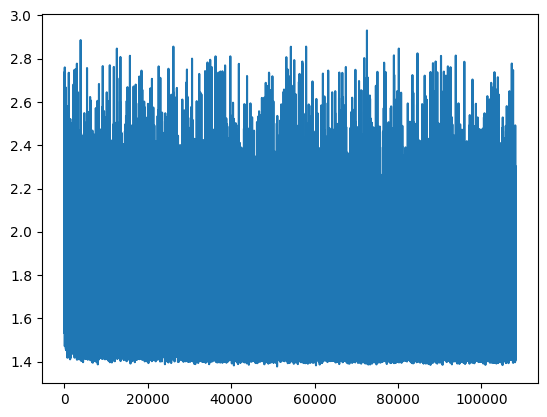

In [113]:
plt.plot(steps, losses)

In [114]:
results = []

for i in range(test_samples_len):
    x = x_test[i]
    y = y_test[i]

    logits = x @ w1
    logits_min, logits_max = logits.min(), logits.max()
    logits_scaled = (logits - logits_min) / (logits_max - logits_min)
    preds = torch.softmax(logits_scaled, dim=0)  
    
    results.append(preds[y])

correct_results = [r for r in results if r > 1 / numbers_to_detect]
accuracy = len(correct_results) * 100 / len(results)
print(f"Validation Accuracy: {accuracy:.2f}%")

Validation Accuracy: 98.05%
